# Distintos tipos de ajustes

In [1]:
# some standard python imports #
import numpy as np
import copy
from astropy.io import fits
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#lenstronomy imports
from lenstronomy.LensModel.lens_model import LensModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.Data.psf import PSF
from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.image_util as image_util
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot

In [3]:
def background_rms_image(cb,image):
    xg,yg = np.shape(image)
    cut0  = image[0:cb,0:cb]
    cut1  = image[xg-cb:xg,0:cb]
    cut2  = image[0:cb,yg-cb:yg]
    cut3  = image[xg-cb:xg,yg-cb:yg]
    std   = np.std([cut0,cut1,cut2,cut3])
    return std

### Importamos la imagen fits que vamos a usar:

/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log10
  import sys


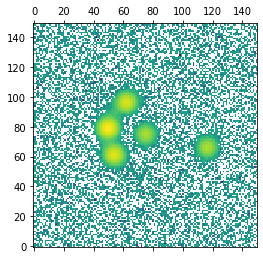

In [4]:
path = '/home/karina/Dropbox/Clase_lens/Clase6/'

hdul = fits.open(path+'fig3.fits')
data=hdul[0].data # or hdul[1]
header = hdul[0].header

plt.matshow(np.log10(data),origin='lower')

### Modulo Data

In [5]:
# data specifics
exp_time = header['EXP_TIME']
numPix = len(data)
deltaPix = header['DELTAPIX']
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix
fwhm = header['fhwm_PSF']
background_rms = background_rms_image(10,data)

x_gl,y_gl = 0,0
ra_at_xy_0, dec_at_xy_0 = x_gl-(deltaPix)*(numPix/2.),y_gl-(deltaPix)*(numPix/2.)

kwargs_data = {'background_rms': background_rms, 'exposure_time':exp_time, 'transform_pix2angle': transform_pix2angle,
               'image_data': data,'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,}
data_class = ImageData(**kwargs_data)

galx,galy = data_class.map_pix2coord(x=76,y=76)
Imx,Imy =data_class.map_pix2coord(x=[65,49,54,125],y=[104,91,57,63])

x_image,y_image = Imx - galx, Imy - galy
x_image,y_image

# PSF specification
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix}
psf_class = PSF(**kwargs_psf)

# Como hacer una mascara:

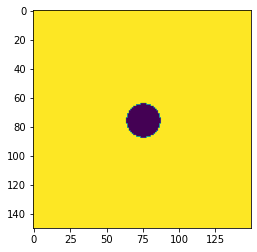

In [6]:
import lenstronomy.Util.util as util
from lenstronomy.Util.mask_util import mask_center_2d

x, y = util.make_grid(numPix=numPix, deltapix=deltaPix)
m=mask_center_2d(galx, galy, 0.7, x, y)
plt.imshow(m.reshape(numPix,numPix))
m_s = m.reshape(numPix,numPix)

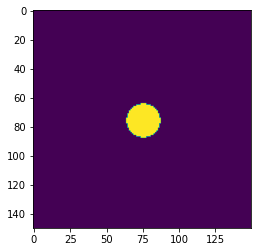

In [7]:
#invertir la mascara:
m0=m-1
m_l=np.where(m0==-1, 1, m0) 
plt.imshow(m_l.reshape(numPix,numPix))
m_l = m_l.reshape(numPix,numPix)

## Aplicar la mascara a la imagen:

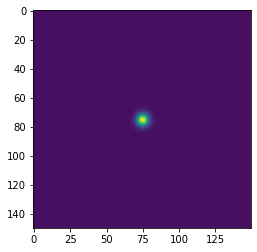

In [8]:
plt.imshow(data*m_l)
data_ml = data*m_l

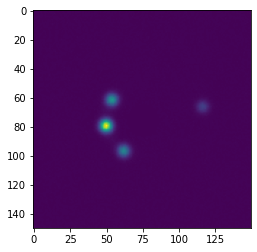

In [9]:
plt.imshow(data*m_s)
data_ms=data*m_s

## Ajuste solo a la lente:

In [19]:
kwargs_data_ml = {'background_rms': background_rms, 'exposure_time':exp_time, 'transform_pix2angle': transform_pix2angle,
               'image_data': data_ml,'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,}
data_class_ml = ImageData(**kwargs_data_ml)


kwargs_constraints = {} 

kwargs_likelihood = {'check_bounds': True}

#aqui se definen los set de datos en cojuntos [data+psf+numerics] 
image_band = [kwargs_data_ml, kwargs_psf, kwargs_numerics]
image_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': image_band_list, 'multi_band_type': 'multi-linear'}

In [20]:
lens_light_model_list = ['SERSIC_ELLIPSE']

kwargs_lens_light_init = [{'R_sersic': 0.1, 'n_sersic': 2.5, 'e1': 0, 'e2': 0, 'center_x': x_gl, 'center_y': y_gl}]
kwargs_lens_light_sigma = [{'R_sersic': 0.1, 'n_sersic': 0.5, 'e1': 0.1, 'e2': 0.1, 'center_x': .1, 'center_y': 0.1}]
kwargs_fixed_lens_light = [{}]
kwargs_lower_lens_light = [{'R_sersic': 0.05, 'n_sersic': 0.5, 'e1': -0.5, 'e2': -0.5, 'center_x': -2, 'center_y': -2}]
kwargs_upper_lens_light = [{'R_sersic': 2, 'n_sersic': 4., 'e1': 0.5, 'e2': 0.5, 'center_x': 2, 'center_y': 2}]

lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, kwargs_fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]

kwargs_params = {'lens_light_model': lens_light_params}
kwargs_model = {'lens_light_model_list': lens_light_model_list}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 0.5,'n_particles': 100, 'n_iterations': 200}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result_ml = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
Converged after 78 iterations!
Best fit found:  -232.3502441895075 [0.07325187636415605, 2.2536574110300562, -0.1385310162259363, -0.016796431667821767, -0.002456637858062474, -0.001568495582347717]
-0.02065978252696461 reduced X^2 of best position
-232.3502441895075 logL
22493.0 effective number of data points
[] lens result
[] source result
[{'amp': 1, 'R_sersic': 0.07325187636415605, 'n_sersic': 2.2536574110300562, 'e1': -0.1385310162259363, 'e2': -0.016796431667821767, 'center_x': -0.002456637858062474, 'center_y': -0.001568495582347717}] lens light result
[] point source result
{} special param result
84.9277892112732 time used for  PSO


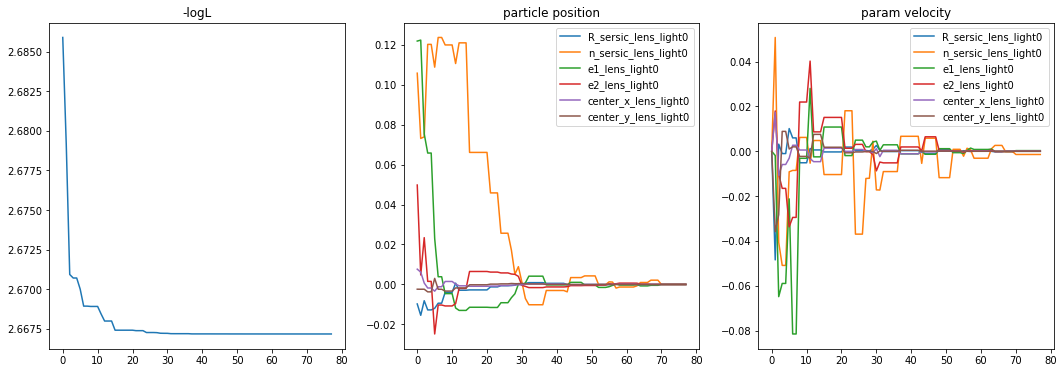

<Figure size 432x288 with 0 Axes>

In [21]:
param_class = fitting_seq.param_class

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)

-0.02065335503906733 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.020653355039067338


/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:55: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_bad(color='k', alpha=1.)
/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:56: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_under('k')
/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:86: RuntimeWarning: divide by zero encountered in log10
 

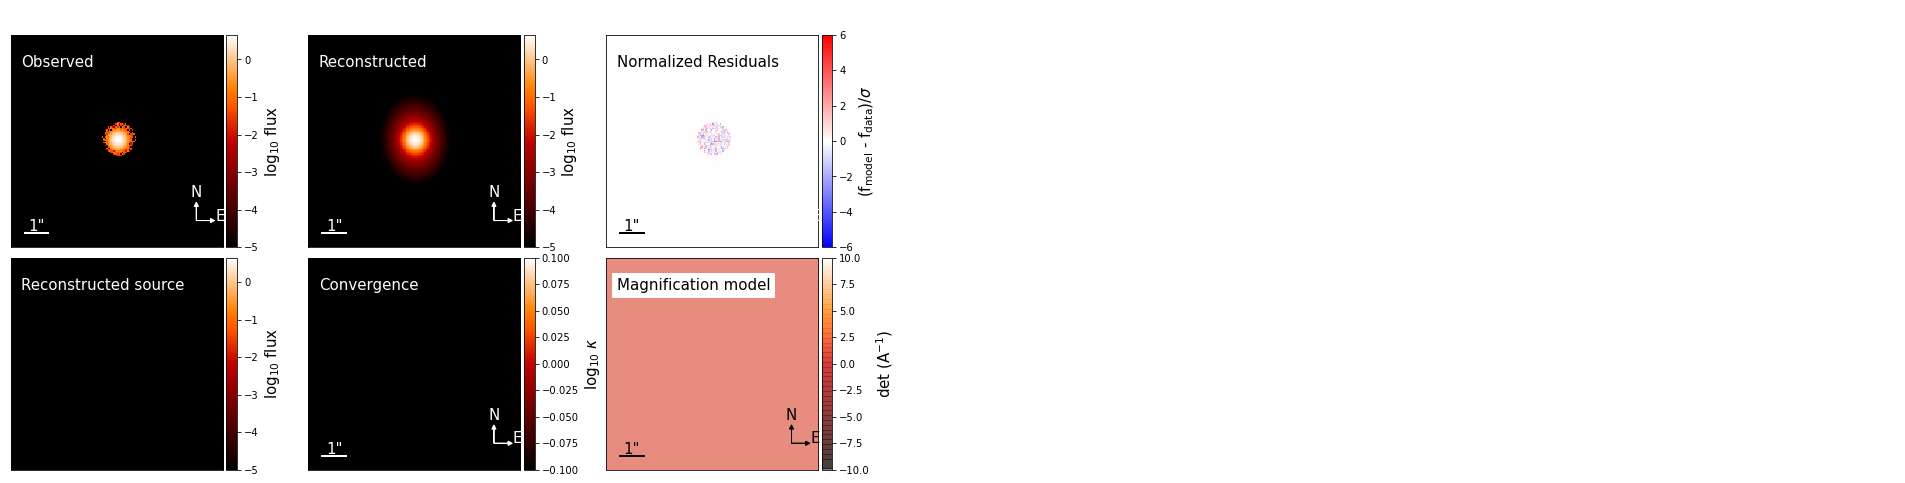

In [22]:
modelPlot = ModelPlot([[kwargs_data_ml, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_result_ml, arrow_size=0.02,cmap_string="gist_heat")

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

In [24]:
kwargs_result_ml

{'kwargs_lens': [],
 'kwargs_source': [],
 'kwargs_lens_light': [{'amp': 2031.4955541738582,
   'R_sersic': 0.07325187636415605,
   'n_sersic': 2.2536574110300562,
   'e1': -0.1385310162259363,
   'e2': -0.016796431667821767,
   'center_x': -0.002456637858062474,
   'center_y': -0.001568495582347717}],
 'kwargs_ps': [],
 'kwargs_special': {},
 'kwargs_extinction': []}

## Ajuste solo del modelo lente

In [25]:
#septup model
lens_model_list = ['SIE']
kwargs_lens_init = [{'theta_E': 1.8, 'e1': -0.138531, 'e2': -0.016796, 'center_x': x_gl, 'center_y':y_gl}]
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2,  'center_x': 0.1, 'center_y': 0.1}]
kwargs_fixed_lens = [{}]
kwargs_lower_lens = [{'theta_E': 1.7, 'e1': -0.2, 'e2': -0.02, 'center_x': -2, 'center_y': -2}]
kwargs_upper_lens = [{'theta_E': 2.0, 'e1': -0.1, 'e2': -0.01, 'center_x': 2, 'center_y': 2}]
lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

point_source_list = ['LENSED_POSITION']
kwargs_ps_init = [{'ra_image': x_image, 'dec_image': y_image}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 4, 'dec_image': [0.02] * 4}]
kwargs_fixed_ps = [{}]
kwargs_lower_ps = [{'ra_image': -2 * np.ones_like(x_image), 'dec_image': -2 * np.ones_like(y_image)}]
kwargs_upper_ps = [{'ra_image': 2 * np.ones_like(x_image), 'dec_image': 2 * np.ones_like(y_image)}]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_fixed_ps, kwargs_lower_ps, kwargs_upper_ps]


kwargs_params = {'lens_model': lens_params,'point_source_model': ps_params}
kwargs_model = {'lens_model_list': lens_model_list,'point_source_model_list': point_source_list}
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
kwargs_constraints = {'num_point_source_list':[4]} 
kwargs_likelihood = {'check_bounds': True,
                     'source_position_tolerance': 0.01,
                     'source_position_sigma': 0.01,
                     'check_matched_source_position': True}

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
image_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': image_band_list, 'multi_band_type': 'multi-linear'}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 0.5,'n_particles': 100, 'n_iterations': 200}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...


/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Sampling/Samplers/pso.py:270: RuntimeWarning: invalid value encountered in double_scalars
  return abs(self.global_best.fitness - mean_fit) < m


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-21.675468691664474 reduced X^2 of best position
-243664.78129734617 logL
22483.0 effective number of data points
[{'theta_E': 1.823297412897899, 'e1': -0.1000246149846436, 'e2': -0.010000394555410588, 'center_x': 0.2748248670256411, 'center_y': 0.07479452740233469}] lens result
[] source result
[] lens light result
[{'ra_image': array([-0.78826644, -1.50975292, -1.27557555, -1.00035853]), 'dec_image': array([ 1.28333756,  0.2493611 , -0.8169352 , -0.75424545]), 'point_amp': [1, 1, 1, 1]}] point source result
{} special param result
199.9071695804596 time used for  PSO


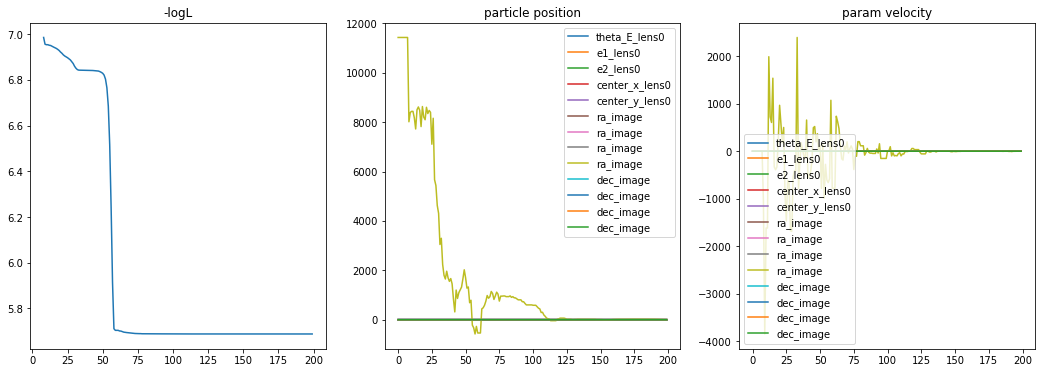

<Figure size 432x288 with 0 Axes>

In [26]:
param_class = fitting_seq.param_class

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)


-21.25230817741929 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  21.25230817741929


/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:39: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:55: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_bad(color='k', alpha=1.)
/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:56: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_h

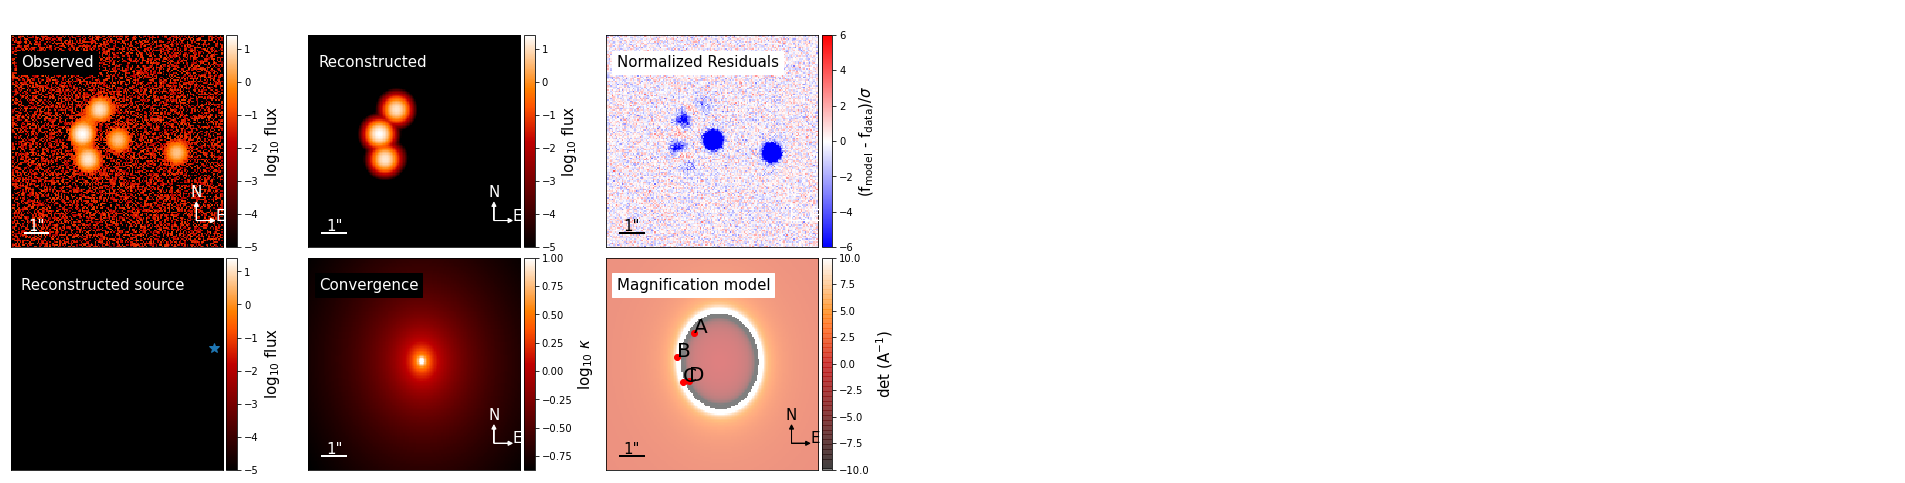

In [27]:
modelPlot = ModelPlot([[kwargs_data, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_result, arrow_size=0.02, 
                      cmap_string="gist_heat")

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

In [28]:
kwargs_result

{'kwargs_lens': [{'theta_E': 1.823297412897899,
   'e1': -0.1000246149846436,
   'e2': -0.010000394555410588,
   'center_x': 0.2748248670256411,
   'center_y': 0.07479452740233469}],
 'kwargs_source': [],
 'kwargs_lens_light': [],
 'kwargs_ps': [{'ra_image': array([-0.78826644, -1.50975292, -1.27557555, -1.00035853]),
   'dec_image': array([ 1.28333756,  0.2493611 , -0.8169352 , -0.75424545]),
   'point_amp': array([ 607.67180999, 1332.05812632,  709.91355584,    2.71001146])}],
 'kwargs_special': {},
 'kwargs_extinction': []}

## Mismo ajuste pero solo con las imagenes

In [31]:
kwargs_data_ms = {'background_rms': background_rms, 'exposure_time':exp_time, 'transform_pix2angle': transform_pix2angle,
               'image_data': data_ms,'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,}
data_class_ms = ImageData(**kwargs_data_ms)


#aqui se definen los set de datos en cojuntos [data+psf+numerics] 
image_band = [kwargs_data_ms, kwargs_psf, kwargs_numerics]
image_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': image_band_list, 'multi_band_type': 'multi-linear'}

In [32]:
#septup model
lens_model_list = ['SIE']
kwargs_lens_init = [{'theta_E': 1.8, 'e1': -0.138531, 'e2': -0.016796, 'center_x': x_gl, 'center_y':y_gl}]
kwargs_lens_sigma = [{'theta_E': 0.3, 'e1': 0.2, 'e2': 0.2,  'center_x': 0.1, 'center_y': 0.1}]
kwargs_fixed_lens = [{}]
kwargs_lower_lens = [{'theta_E': 1.7, 'e1': -0.2, 'e2': -0.02, 'center_x': -2, 'center_y': -2}]
kwargs_upper_lens = [{'theta_E': 2.0, 'e1': -0.1, 'e2': -0.01, 'center_x': 2, 'center_y': 2}]
lens_params = [kwargs_lens_init, kwargs_lens_sigma, kwargs_fixed_lens, kwargs_lower_lens, kwargs_upper_lens]

point_source_list = ['LENSED_POSITION']
kwargs_ps_init = [{'ra_image': x_image, 'dec_image': y_image}]
kwargs_ps_sigma = [{'ra_image': [0.02] * 4, 'dec_image': [0.02] * 4}]
kwargs_fixed_ps = [{}]
kwargs_lower_ps = [{'ra_image': -2 * np.ones_like(x_image), 'dec_image': -2 * np.ones_like(y_image)}]
kwargs_upper_ps = [{'ra_image': 2 * np.ones_like(x_image), 'dec_image': 2 * np.ones_like(y_image)}]
ps_params = [kwargs_ps_init, kwargs_ps_sigma, kwargs_fixed_ps, kwargs_lower_ps, kwargs_upper_ps]


kwargs_params = {'lens_model': lens_params,'point_source_model': ps_params}
kwargs_model = {'lens_model_list': lens_model_list,'point_source_model_list': point_source_list}
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}
kwargs_constraints = {'num_point_source_list':[4],'image_plane_source_list':[4]} 
kwargs_likelihood = {'check_bounds': True,
                     'source_position_tolerance': 0.01,
                     'source_position_sigma': 0.01,
                     'check_matched_source_position': True}

image_band = [kwargs_data, kwargs_psf, kwargs_numerics]
image_band_list = [image_band]
kwargs_data_joint = {'multi_band_list': image_band_list, 'multi_band_type': 'multi-linear'}

fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['PSO', {'sigma_scale': 0.5,'n_particles': 100, 'n_iterations': 200}]]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
Max iteration reached! Stopping.
-21.669519524810035 reduced X^2 of best position
-243597.903738152 logL
22483.0 effective number of data points
[{'theta_E': 1.7000252649147611, 'e1': -0.10007855602285765, 'e2': -0.012302444958192313, 'center_x': 0.16390014045794757, 'center_y': -0.04475556425159737}] lens result
[] source result
[] lens light result
[{'ra_image': array([-0.78612308, -1.51309527, -1.27486123,  1.99997556]), 'dec_image': array([ 1.28510547,  0.25017358, -0.81352672, -0.76721747]), 'point_amp': [1, 1, 1, 1]}] point source result
{} special param result
142.46738862991333 time used for  PSO


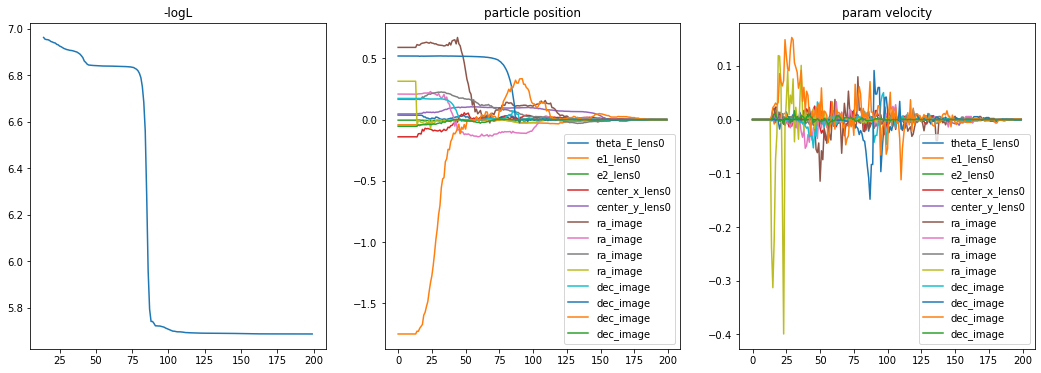

<Figure size 432x288 with 0 Axes>

In [33]:
param_class = fitting_seq.param_class

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)

-11.178941827232709 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  11.178941827232705


/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:39: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)
/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:55: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_heat"))
  cmap.set_bad(color='k', alpha=1.)
/home/karina/miniconda3/envs/LENS/lib/python3.7/site-packages/lenstronomy/Plots/model_band_plot.py:56: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("gist_h

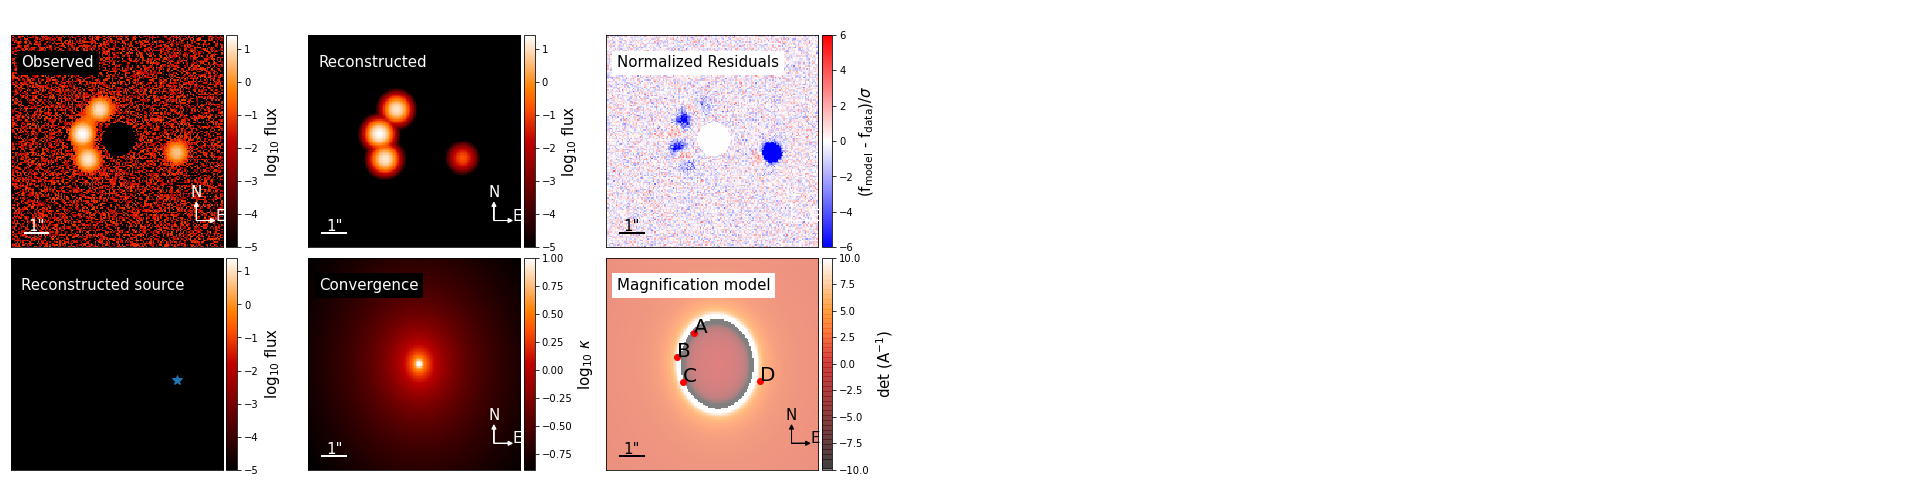

In [34]:
modelPlot = ModelPlot([[kwargs_data_ms, kwargs_psf, kwargs_numerics]], kwargs_model, kwargs_result, arrow_size=0.02, 
                      cmap_string="gist_heat")

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

In [35]:
kwargs_result

{'kwargs_lens': [{'theta_E': 1.7000252649147611,
   'e1': -0.10007855602285765,
   'e2': -0.012302444958192313,
   'center_x': 0.16390014045794757,
   'center_y': -0.04475556425159737}],
 'kwargs_source': [],
 'kwargs_lens_light': [],
 'kwargs_ps': [{'ra_image': array([-0.78612308, -1.51309527, -1.27486123,  1.99997556]),
   'dec_image': array([ 1.28510547,  0.25017358, -0.81352672, -0.76721747]),
   'point_amp': array([ 607.73222914, 1331.88297523,  711.64709405,    8.71091998])}],
 'kwargs_special': {},
 'kwargs_extinction': []}